<span style="font-size:30px">**Filtros de dominio de frecuencia, parte 1: Filtro Pasa Bajas.**</span> 
    
<span style="font-family: 'Verdana'; color: red;"> *Bronquivoide* </span>

# Introducción:

### En otros notebook anteriores habíamos abordado el tema de filtros en el dominio original donde es procesada la imagen, el cual es el dominio espacial. Ahora nos corresponde abordar este sobre filtros pero en el dominio de frecuencias.

### Este notebook tiene como antecedente el notebook sobre la transformada discreta de Fourier, pues se extiende la teoría sobre dominios espaciales y de frecuencia a los procesos de filtrado. También tomamos como base lo abordado para filtros en señales continuas temporalmente (analógicas) representadas analíticamente mediante una función $f(t)$, para implementarlo a imágenes, representadas por una función bidimensional de términos espaciales $f(x,t)$.

### El proceso de filtrado en el dominio de frecuencias de una imagen puede ser caracterizado por cuatro pasos:

### 1) Calcular la DFT de la imagen.

### 2) Diseñar un filtro en el dominio de frecuencias (kernel) y una frecuencia de corte.

### 3) Usar el teorema de la convolución para multiplicar el resultado de la DFT con el kernel del paso anterior (como lo vimos en el notebook sobre la transformada discreta de Fourier).

### 4) Calcular la DFT inversa para establecer la imagen filtrada.

### Estos cuatro pasos se traducen en las ecuaciones que teníamos en el notebook de la DFT:

<font size="5"> $g(x,y)= h(x,y) \diamond f(x,y)$</font>

<font size="5"> $\Rightarrow$</font>

<font size="5"> $DFT[g(x,y)]= DFT[h(x,y)] \cdot DFT[f(x,y)]$</font>

<font size="5"> $\Rightarrow$</font>

<font size="5"> $G(u,v)= H(u,v)\cdot F(u,v)$</font>

<font size="5"> $\Rightarrow$</font>

### Por lo que en estos términos, la imagen procesada es:

<font size="5"> $g(x,y)=DFT ^{-1}[H(u,v)\cdot F(u,v)]$</font>

### Uno de los filtros de dominio de frecuencias más importantes es el filtro pasa bajas, el cual tiene tres variantes: Ideal, *Mantequilla (Butterworth)* y gaussiano. El que abordaremos en este notebook a detalle e implementaremos en Python será el ideal.

### Habíamos visto en el repositorio de procesamiento de señales (https://github.com/Bronquivoide/Signal-Proccesing-con-Python/tree/main) que el kernel que caracterizaba a un filtro pasa bajas ideal en el dominio de frecuencias era de la forma $H(\omega)$, definiendo una frecuencia de corte $\omega _c$. Bajo esta descripción, lo que hacía el filtro pasa bajas en señales analógicas es que permitía pasar frecuencias tal que $-\omega _c \leq \omega \leq \omega _c$ y rechazaba cualquier otro conjunto de frecuencias.

### En el caso de procesamiento de imágenes, para un filtro pasa bajas ideal vamos a tener un kernel de la forma $H(u,v)$. Nótese que en este caso el concepto de frecuencias es un poco más abstracto, puesse aborda con base a términos espaciales, por lo que lo que vendría a ser la frecuencia de corte es un término espacial. Lo que hace este filtro ideal es pasar todas las frecuencias implicadas en el procesamiento de la imagen sin atenuación dentro de un círculo de radio $D_0$ mientras que atenúa por completo cualquier otro conjunto de frecuencias.

### Para el filtro pasa bajas ideal en el procesamiento de imagen, se define la siguiente función filtro de orden $P \times Q$:

<font size="5"> $H_{LP}(u,v) =
\begin{cases}
1, & \text{si } D(u,v) \leq D_0 \\
0, & \text{si } D(u,v) > D_0
\end{cases}$</font>

<font size="5"> $\forall u=0,1,\dots ,P-1$</font>

<font size="5"> $\forall v=0,1,\dots ,Q-1$</font>

### En donde $D_0 $ es la frecuencia de corte y $D(u,v)$ es la distancia euclidiana entre un pixel o punto caracterizado por la tupla de frecuencias $(u,v)$ y el centro del círculo:

<font size="5"> $D(u,v):=\sqrt{(u-\frac{P}{2})^2+(v-\frac{Q}{2})^2}$</font>

### Las otras dos clasificaciones de filtro pasa bajas están caracterizadas por las siguientes funciones de filtrado:

### $\blacksquare$ Mantequilla:

<font size="5"> $H(u,v)= [1+(\frac{D(u,v)}{D_0})^{2n}]^{-1}$</font>

### $\blacksquare$ Gaussiano:

<font size="5"> $H(u,v)= exp[-\frac{D^2 (u,v)}{2\sigma ^2}]$, en donde se define $\sigma =D_0$</font>

# Ejercicio:

### Basándose en los cuatro pasos expuestos y en el notebook sobre la transformada discreta de Fourier en imágenes, implementar un filtro pasa bajas sobre *Lena.tif* con OpenCV.


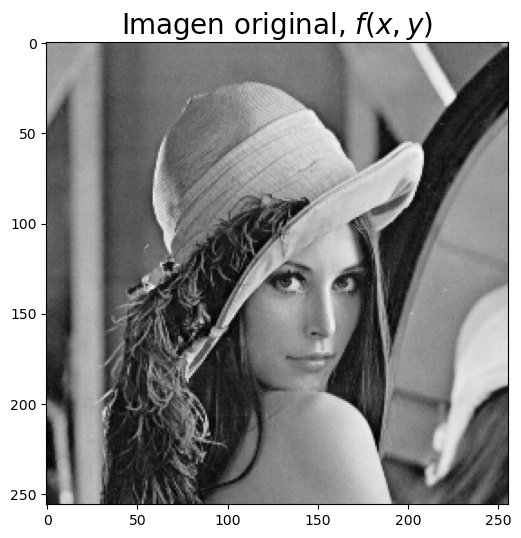

El orden de la imagen es de 256 x 256


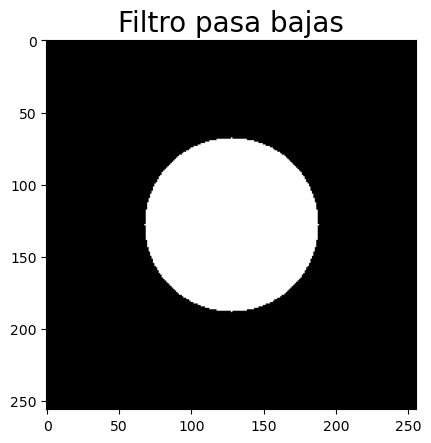

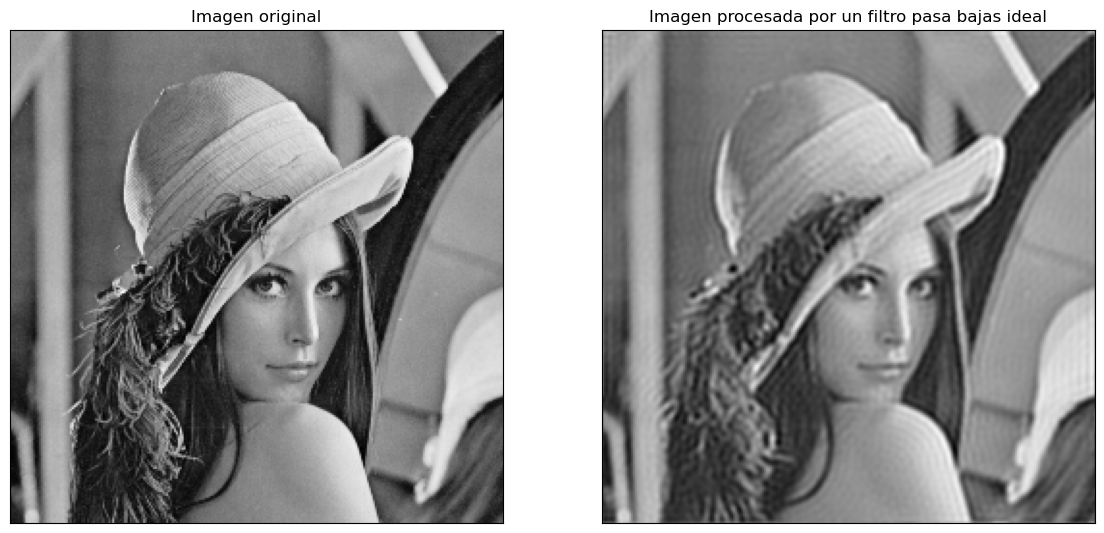

In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#Display de la imagen original:
imagen_original=cv2.imread('Lena.tif', 0)
plt.figure(figsize=(12,6))
plt.imshow(imagen_original, cmap = 'gray')
plt.title(r"Imagen original, $f(x,y)$",fontsize=20)
plt.show()

#Paso 1, cálculo de la DFT de la imagen:
DFT=cv2.dft(np.float32(imagen_original),flags=cv2.DFT_COMPLEX_OUTPUT) #cv2.DFT_COMPLEX_OUTPUT genera una DFT completa dando un complejo, descrito por la suma Re+iIm.
DFT_ordenada=np.fft.fftshift(DFT)

#Paso 2, diseño del filtro circular:
renglones,columnas= imagen_original.shape
print(f"El orden de la imagen es de {renglones} x {columnas}")
    #Definiendo las coordenadas del centro del círculo, se toma el operador // para regresar la parte entera, pues trabajamos con un sistema discreto
centro_ren, centro_col = renglones//2 , columnas//2  
    #Arreglo de ceros tal que el círculo sea un arreglo de unos
kernel= np.zeros((renglones,columnas, 2), np.float32)
    #Radio del círculo:
D0=60 
centro = [centro_ren, centro_col]
x, y = np.ogrid[:renglones, :columnas] #malla discreta
área_kernel= (x - centro[0]) ** 2 + (y - centro[1]) ** 2 <= D0 * D0
kernel[área_kernel] = 1
    #Display del arreglo asociado al filtro
filtro= cv2.magnitude(kernel[:,:,0] ,kernel[:,:,1]) #Módulo, toma la parte real y la imaginaria
plt.imshow(filtro, cmap = 'gray')
plt.title("Filtro pasa bajas",fontsize=20)
plt.show()

#Paso 3, multiplicar el resultado de la DFT  con el filtro:
producto= DFT_ordenada * kernel

#Paso 4, calcular la IDFT:
IDFT= np.fft.ifftshift(producto)
imagen_salida = cv2.idft(IDFT)
imagen_salida= cv2.magnitude(imagen_salida[:,:,0],imagen_salida[:,:,1])

#Display de la imagen de salida:
plt.figure(figsize = (14,7))
plt.subplot(121)
plt.imshow(imagen_original, cmap = 'gray')
plt.title('Imagen original')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(imagen_salida, cmap = 'gray')
plt.title('Imagen procesada por un filtro pasa bajas ideal')
plt.xticks([])
plt.yticks([])
plt.show()      


# Fin del ejercicio.

### Bibliografía recomendada:

### $\blacksquare$ Gonzalez, R. C., & Woods, R. E. (2008). Digital image processing (3rd ed.). Pearson.

### $\blacksquare$ Acharya, T., & Ray, A. K. (2005). Image processing: Principles and applications. Wiley-Interscience.